<a href="https://colab.research.google.com/github/JoaoEmanuel14/API_Laravel_BD/blob/main/Modelo5_FaceNet_ArcFace_SCface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importando bibliotecas e dependências, além de fazer device-agnostic code

In [ ]:
!nvidia-smi

Tue Jul 15 12:38:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Montar Google Colab para ter acesso ao dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalando bibliotecas necessárias
!pip install facenet-pytorch --no-deps
!pip install -q -U albumentations mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics.pairwise import euclidean_distances

import os
import re
import zipfile
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
import copy

In [ ]:
print(f"Versão do PyTorch: {torch.__version__}")

Versão do PyTorch: 2.6.0+cu124


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Variáveis globais
SEED = 42
EPOCHS = 30
BATCH_SIZE = 32
IMG_SIZE = 160
LEARNING_RATE = 0.00005
WEIGHT_DECAY = 0.00001

# 1. Pegar os dados do SCface

## 1.1 Descompactando o dataset e definindo os caminhos para as pastas do dataset

In [ ]:
# Caminho zip do drive
zip_path = '/content/drive/MyDrive/PIBIC 2024-2025/SCface.zip'

# Caminho para qual iremos extrair
extract_path = Path("/content/scface_data")

# Extrai se o diretório de destino não existir
if not extract_path.exists():
    print(f"Criando diretório e descompactando em: {extract_path}")
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extraído com sucesso.")
else:
    print(f"Diretório '{extract_path}' já existe. Extração pulada.")

Criando diretório e descompactando em: /content/scface_data
Dataset extraído com sucesso.


In [ ]:
# Definindo os caminhos para o dataset
SCface_path = extract_path / "SCface_database"


surveillance_cameras_IR_cam8_path = SCface_path / "surveillance_cameras_IR_cam8"
surveillance_cameras_distance_1_path = SCface_path / "surveillance_cameras_distance_1"
surveillance_cameras_distance_2_path = SCface_path / "surveillance_cameras_distance_2"
surveillance_cameras_distance_3_path = SCface_path / "surveillance_cameras_distance_3"

SCFACE_TRAIN_VAL_PATH = SCface_path / "mugshot_frontal_original_all"
SCFACE_MUGSHOT_FRONTAL_PATH = SCface_path / "mugshot_frontal_cropped_all"
SCFACE_MUGSHOT_ROTATION_PATH= SCface_path / "mugshot_rotation_all"
SCFACE_PROBE_PATH = SCface_path / "surveillance_cameras_all"

In [ ]:
print("Carregando e combinando imagens da galeria frontal e de rotação...")
frontal_files = list(Path(SCFACE_MUGSHOT_FRONTAL_PATH).glob('*.jpg'))
rotation_files = list(Path(SCFACE_MUGSHOT_ROTATION_PATH).glob('*.jpg'))
all_gallery_filepaths = frontal_files + rotation_files # Lista combinada
print(f"Total de {len(all_gallery_filepaths)} imagens de alta qualidade encontradas para treino/validação.")

Carregando e combinando imagens da galeria frontal e de rotação...
Total de 1170 imagens de alta qualidade encontradas para treino/validação.


In [ ]:
# Listar os diretórios dentro do caminho extraído
print(f"Conteúdo do diretório {extract_path}:")
for item in os.listdir(extract_path):
  print(item)

if SCFACE_MUGSHOT_FRONTAL_PATH.exists():
  print(f"\nConteúdo do diretório {SCFACE_MUGSHOT_FRONTAL_PATH}:")
  for item in sorted(os.listdir(SCFACE_MUGSHOT_FRONTAL_PATH)):
      print(item)
else:
  print(f"\nDiretório {SCFACE_MUGSHOT_FRONTAL_PATH} não encontrado.")

Conteúdo do diretório /content/scface_data:
SCface_database

Conteúdo do diretório /content/scface_data/SCface_database/mugshot_frontal_cropped_all:
001_frontal.JPG
002_frontal.JPG
003_frontal.JPG
004_frontal.JPG
005_frontal.JPG
006_frontal.JPG
007_frontal.JPG
008_frontal.JPG
009_frontal.JPG
010_frontal.JPG
011_frontal.JPG
012_frontal.JPG
013_frontal.JPG
014_frontal.JPG
015_frontal.JPG
016_frontal.JPG
017_frontal.JPG
018_frontal.JPG
019_frontal.JPG
020_frontal.JPG
021_frontal.JPG
022_frontal.JPG
023_frontal.JPG
024_frontal.JPG
025_frontal.JPG
026_frontal.JPG
027_frontal.JPG
028_frontal.JPG
029_frontal.JPG
030_frontal.JPG
031_frontal.JPG
032_frontal.JPG
033_frontal.JPG
034_frontal.JPG
035_frontal.JPG
036_frontal.JPG
037_frontal.JPG
038_frontal.JPG
039_frontal.JPG
040_frontal.JPG
041_frontal.JPG
042_frontal.JPG
043_frontal.JPG
044_frontal.JPG
045_frontal.JPG
046_frontal.JPG
047_frontal.JPG
048_frontal.JPG
049_frontal.JPG
050_frontal.JPG
051_frontal.JPG
052_frontal.JPG
053_frontal.JPG
054

## 1.2 Visualizando o dataset

Caminho de imagem aleatorio: /content/scface_data/SCface_database/surveillance_cameras_all/115_cam2_3.jpg
Classe da imagem: surveillance_cameras_all
Altura da imagem: 224
Comprimento da imagem: 168


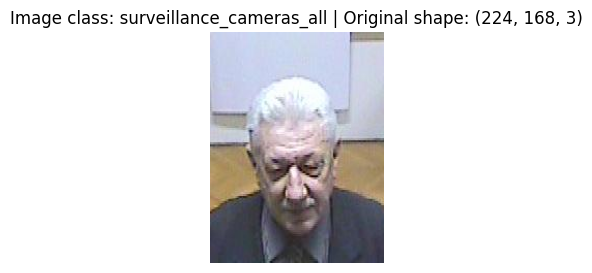

In [ ]:
import random

if SCface_path.exists():
  # Lista de imagens do SCface_path
  image_path_list = list(SCface_path.glob("*/*.jpg"))

  if image_path_list:
    # Pega uma imagem aleatória e a "abre"
    random_image_path = random.choice(image_path_list)
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)

    # Característica da imagem
    print(f"Caminho de imagem aleatorio: {random_image_path}")
    print(f"Classe da imagem: {image_class}")
    print(f"Altura da imagem: {img.height}")
    print(f"Comprimento da imagem: {img.width}")

    # Plotando imagem com matplotlib
    img_array = np.asarray(img)
    plt.figure(figsize=(5, 3)) # Ajustado tamanho
    plt.imshow(img_array)
    plt.title(f"Image class: {image_class} | Original shape: {img_array.shape}")
    plt.axis(False)
    plt.show()
  else:
    print(f"Nenhuma imagem encontrada em {SCface_path}")
else:
  print(f"Diretório de treino não encontrado: {SCface_path}")

# 2. Transforms das imagens

In [ ]:
# Transforms de treino
train_transform = A.Compose([
    # Passo 1: Simular a perda de resolução
    A.Downscale(scale_min=0.25, scale_max=0.5, interpolation=0, p=0.75), # Reduz drasticamente a resolução

    # Passo 2: Simular compressão de vídeo/imagem
    A.ImageCompression(quality_lower=40, quality_upper=80, p=0.75),

    # Passo 3: Adicionar ruído e blur típicos de câmeras
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.ISONoise(p=0.5),
    ], p=0.5),

    A.OneOf([
        A.MotionBlur(p=0.3),
        A.GaussianBlur(p=0.5),
    ], p=0.5),

    # Passo 4: Ajustes de cor e brilho
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    # Passo 5: Redimensionar de volta para o tamanho do modelo e normalizar
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
])

# Transforms da avaliação
val_test_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
])

/tmp/ipython-input-13-104844766.py:4: UserWarning: Argument(s) 'scale_min, scale_max, interpolation' are not valid for transform Downscale
  A.Downscale(scale_min=0.25, scale_max=0.5, interpolation=0, p=0.75), # Reduz drasticamente a resolução
/tmp/ipython-input-13-104844766.py:7: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=40, quality_upper=80, p=0.75),


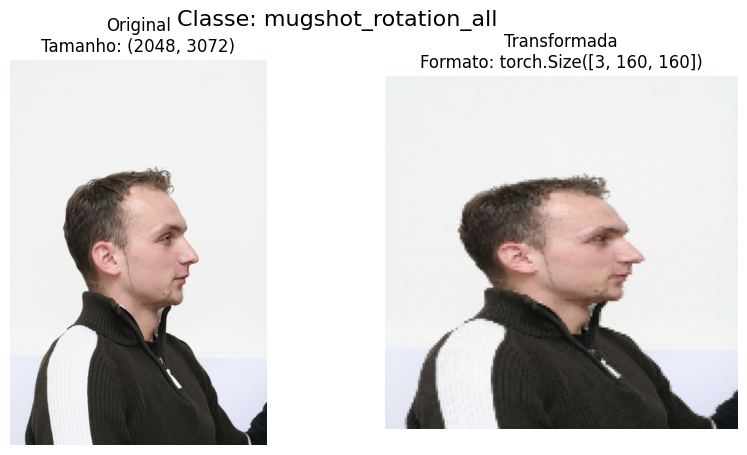

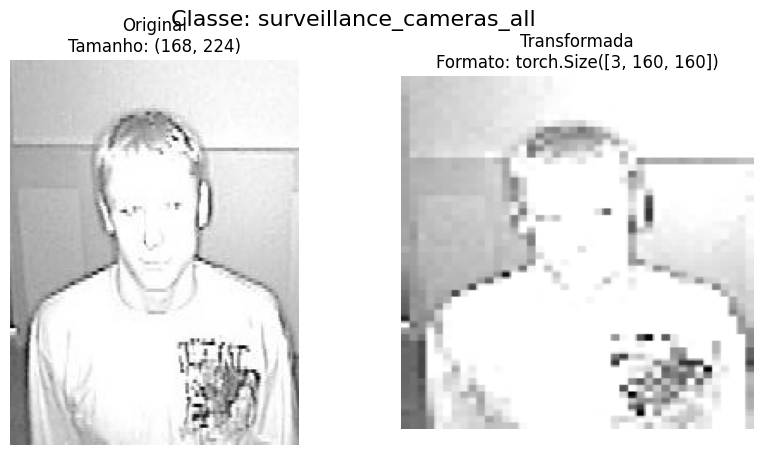

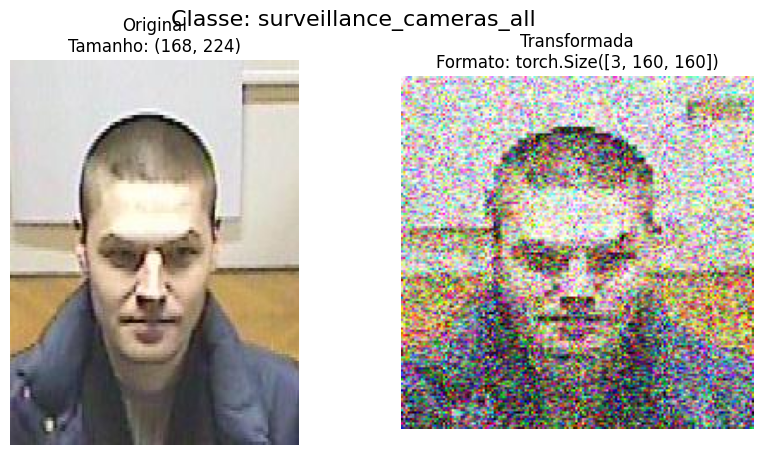

In [ ]:
def plot_imagens_transformadas(image_paths, transform, n=3, seed=None):
  """
  Plota algumas imagens do dataset antes e depois de serem transformadas,
  juntamente de informações como: tamanho original e tamanho dps de transformada.

  :param image_paths: Caminho de uma lista de imagens
  :param transform: Operação de transformação que será aplicado a imagem
  :param n: Número de imagens que serão plotadas
  :param seed: Semente para obter resultados determinísticos (ou não)

  :return matplotlib com imagens transformadas
  """
  if not image_paths:
    print("Nenhum caminho de imagem fornecido para plot_imagens_transformadas.")
    return
  if seed:
    random.seed(seed)

  num_available_images = len(image_paths)

  actual_n = min(n, num_available_images)

  if actual_n == 0:
    print("Nenhuma imagem disponível para plotar.")
    return

  random_image_paths = random.sample(image_paths, k=actual_n)

  for image_path in random_image_paths:
    # Carregue a imagem original com PIL
    original_img = Image.open(image_path)
    # Converta a imagem PIL para um array NumPy para a Albumentations
    original_img_np = np.array(original_img)

    # Plote a imagem original
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(original_img_np)
    ax[0].set_title(f"Original\nTamanho: {original_img.size}")
    ax[0].axis(False)

    transformed = transform(image=original_img_np)
    transformed_image_tensor = transformed['image']

    # Permute as dimensões do tensor (C, H, W) para (H, W, C) para plotar com Matplotlib
    ax[1].imshow(transformed_image_tensor.permute(1, 2, 0))
    ax[1].set_title(f"Transformada\nFormato: {transformed_image_tensor.shape}")
    ax[1].axis(False)

    fig.suptitle(f"Classe: {image_path.parent.stem}", fontsize=16)
    plt.show()

if SCface_path.exists() and image_path_list:
  plot_imagens_transformadas(image_path_list,
                             transform=train_transform,
                             n=3)

# 3. Criando a classe Dataset e os DataLoaders para o SCface

Aqui, a gallery representa as imagens que representam as fotos de rostos, "estilo 3x4" e o probe representa as imagens de câmeras de segurança.

## 3.1 Classe do Dataset

In [ ]:
def load_scface_data_with_map(directory_path, label_map):
  """
  Carrega os caminhos das imagens e extrai os rótulos para o dataset Scface.
  Assume que o ID da pessoa é o número no início do nome do arquivo.
  """
  filepaths, labels = [], []

  dir_path = Path(directory_path)

  if not dir_path.exists():
    raise FileNotFoundError(f"Diretório não encontrado: {dir_path}")

  for filepath in dir_path.glob('*.jpg'):
    match = re.match(r'(\d+)', filepath.name)
    if match:
      id_str = match.group(1)

      # Usa o mapa de rótulos unificado para encontrar o ID numérico correto
      if id_str in label_map:
        filepaths.append(filepath)
        labels.append(label_map[id_str])

  return filepaths, labels

In [ ]:
# Classe de Dataset para o SCface
class SCfaceDataset(Dataset):
  def __init__(self, filepaths, labels, transform=None):
    self.filepaths, self.labels, self.transform = filepaths, labels, transform

  def __len__(self):
    return len(self.filepaths)

  def __getitem__(self, idx):
    img_path, label = self.filepaths[idx], self.labels[idx]

    img = Image.open(img_path).convert("RGB")

    img_np = np.array(img)

    if self.transform:
      img_tensor = self.transform(image=img_np)['image']

    else:
      img_tensor = torch.from_numpy(img_np.transpose(2,0,1)).float() / 255.0

    return img_tensor, label, str(img_path)

## 3.2 Criação dos Datasets e DataLoaders

In [ ]:
# 1: Criar o mapa de rótulos unificado a partir da galeria
# A gallery geralmente contém todas as identidades que podem aparecer nas sondas.
print("Criando mapa de rótulos unificado a partir da gallery...")

all_ids_str = sorted(list(set([re.match(r'(\d+)', f.name).group(1) for f in all_gallery_filepaths])))
unified_label_map = {id_str: i for i, id_str in enumerate(all_ids_str)}
NUM_SCFACE_CLASSES = len(unified_label_map)
print(f"Mapa unificado criado com {NUM_SCFACE_CLASSES} identidades.")

# 2. Carregar os dados da galeria (que serão nosso treino/validação)
all_gallery_labels = [unified_label_map[re.match(r'(\d+)', f.name).group(1)] for f in all_gallery_filepaths]

print(f"Número total de amostras na galeria antes do filtro: {len(all_gallery_labels)}")

# 3. Dividir a galeria em treino e validação (80/20) de forma estratificada
print("Dividindo dados de treino e validação...")
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

train_indices, val_indices = next(splitter.split(all_gallery_filepaths, all_gallery_labels))

# Criar os datasets de treino e validação
train_dataset = SCfaceDataset([all_gallery_filepaths[i] for i in train_indices], [all_gallery_labels[i] for i in train_indices], transform=train_transform)
val_dataset = SCfaceDataset([all_gallery_filepaths[i] for i in val_indices], [all_gallery_labels[i] for i in val_indices], transform=val_test_transform)

# 4. Criar os DataLoaders de treino e validação (com num_workers)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders de treino ({len(train_dataset)} imgs) e validação ({len(val_dataset)} imgs) criados.")

# 5. Criar o DataLoader de teste (sondas) (com lógica mais robusta)
print("Criando DataLoader de teste (sondas)...")
probe_filepaths_all = list(Path(SCFACE_PROBE_PATH).glob('*.jpg')) # Ajuste a extensão

# <<< LÓGICA CORRIGIDA E MAIS SEGURA >>>
# Usamos .get() que retorna None se a chave não existir, evitando erros
probe_labels_all = [unified_label_map.get(re.match(r'(\d+)', p.name).group(1)) for p in probe_filepaths_all]

# Filtramos as imagens de sonda que não têm uma identidade correspondente na galeria
probe_data_filtered = [(fp, lbl) for fp, lbl in zip(probe_filepaths_all, probe_labels_all) if lbl is not None]
probe_filepaths, probe_labels = zip(*probe_data_filtered)

# Criamos o dataset e o dataloader apenas com as sondas válidas
probe_dataset = SCfaceDataset(list(probe_filepaths), list(probe_labels), transform=val_test_transform)

probe_loader = DataLoader(probe_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print(f"DataLoader de teste ({len(probe_dataset)} imgs) criado.")

Criando mapa de rótulos unificado a partir da gallery...
Mapa unificado criado com 130 identidades.
Número total de amostras na galeria antes do filtro: 1170
Dividindo dados de treino e validação...
DataLoaders de treino (936 imgs) e validação (234 imgs) criados.
Criando DataLoader de teste (sondas)...
DataLoader de teste (2860 imgs) criado.


# 4. Treinamento do Modelo

In [ ]:
# 3. Classes do Modelo com ArcFace
from facenet_pytorch import InceptionResnetV1

class ArcFace(nn.Module):
    # ... (código da classe ArcFace, sem alterações) ...
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFace, self).__init__()
        self.in_features, self.out_features, self.s, self.m = in_features, out_features, s, m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, emb, lbl):
        cosine = F.linear(F.normalize(emb), F.normalize(self.weight))
        theta, one_hot = torch.acos(torch.clamp(cosine, -1, 1)), torch.zeros_like(cosine)
        one_hot.scatter_(1, lbl.view(-1, 1).long(), 1)
        output = self.s * ((one_hot * torch.cos(theta + self.m)) + ((1 - one_hot) * cosine))
        return output

class FaceRecognitionModelWithArcFace(nn.Module):
    def __init__(self, num_classes, embedding_size=512):
        super(FaceRecognitionModelWithArcFace, self).__init__()
        self.backbone = InceptionResnetV1(pretrained='vggface2', classify=False) # Usa o conhecimento prévio!
        self.head = ArcFace(in_features=embedding_size, out_features=num_classes)
    def forward(self, image, label):
        embedding = self.backbone(image)
        logits = self.head(embedding, label)
        return logits

In [ ]:
# 1. Inicializar modelo, otimizador e perda
print("Inicializando novo modelo para fine-tuning no Scface...")
scface_model = FaceRecognitionModelWithArcFace(num_classes=NUM_SCFACE_CLASSES).to(device)
optimizer = optim.Adam(scface_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Inicializando novo modelo para fine-tuning no Scface...


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
print("Iniciando o processo de treinamento...")
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
early_stopping_patience = 10 # O treino para se a Val Loss não melhorar por 10 épocas seguidas

start_time_total_train = timer()

for epoch in range(EPOCHS):
    # --- Fase de Treinamento ---
    scface_model.train()
    running_loss_train = 0.0
    running_acc_train = 0.0
    train_batches = 0

    loop_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Treino]", leave=False)

    for images, labels, _ in loop_train:
        images, labels = images.to(device), labels.to(device)

        # Forward pass com imagem e rótulo para o ArcFace
        logits = scface_model(images, labels)

        # Calcular a perda
        loss = loss_fn(logits, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular métricas
        running_loss_train += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_acc_train += (preds == labels).float().mean().item()
        train_batches += 1
        loop_train.set_postfix(loss=loss.item())

    avg_loss_train = running_loss_train / train_batches
    avg_acc_train = running_acc_train / train_batches

    # --- Fase de Validação ---
    scface_model.eval()
    running_loss_val = 0.0
    running_acc_val = 0.0
    val_batches = 0

    with torch.inference_mode():
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validação]", leave=False)
        for images, labels, _ in loop_val:
            images, labels = images.to(device), labels.to(device)

            # Forward pass com imagem e rótulo
            logits = scface_model(images, labels)

            # Calcular perda
            loss = loss_fn(logits, labels)
            running_loss_val += loss.item()

            # Calcular acurácia
            preds = torch.argmax(logits, dim=1)
            running_acc_val += (preds == labels).float().mean().item()
            val_batches += 1
            loop_val.set_postfix(val_loss=loss.item())

    avg_loss_val = running_loss_val / val_batches
    avg_acc_val = running_acc_val / val_batches

    print(f"Epoch {epoch+1}/{EPOCHS} | Treino Loss: {avg_loss_train:.4f}, Treino Acc: {avg_acc_train:.4f} | "
          f"Val Loss: {avg_loss_val:.4f}, Val Acc: {avg_acc_val:.4f}")

    # Atualizar o scheduler com a perda de validação
    scheduler.step(avg_loss_val)

    # Lógica para salvar o melhor modelo e Early Stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        best_model_state = copy.deepcopy(scface_model.state_dict())
        patience_counter = 0
        print(f"  🎉 Novo melhor modelo encontrado! Val Loss: {best_val_loss:.4f}. Salvando estado...")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"  ⚠️ Early stopping na Época {epoch + 1} pois a perda de validação não melhorou por {early_stopping_patience} épocas.")
        break # Interrompe o loop de treinamento

end_time_total_train = timer()
print(f"\nTempo total de treinamento: {end_time_total_train - start_time_total_train:.3f} segundos")

# --- Fim do Loop ---
if best_model_state:
    print("✅ Treinamento concluído. O melhor estado do modelo foi salvo na memória.")
    # Salvar o modelo final no disco
    torch.save(best_model_state, 'scface_best_model.pth')
    print("Melhor modelo salvo em 'scface_best_model.pth'")
else:
    print("❌ Treinamento concluído, mas nenhum modelo foi salvo (verifique se o treino rodou por pelo menos uma época).")

Iniciando o processo de treinamento...


Epoch 1/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/30 | Treino Loss: 19.5019, Treino Acc: 0.0000 | Val Loss: 18.4710, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 18.4710. Salvando estado...


Epoch 2/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/30 | Treino Loss: 17.4389, Treino Acc: 0.0000 | Val Loss: 16.9195, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 16.9195. Salvando estado...


Epoch 3/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/30 | Treino Loss: 15.8399, Treino Acc: 0.0000 | Val Loss: 15.7021, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 15.7021. Salvando estado...


Epoch 4/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/30 | Treino Loss: 14.5026, Treino Acc: 0.0000 | Val Loss: 14.5939, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 14.5939. Salvando estado...


Epoch 5/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/30 | Treino Loss: 13.2570, Treino Acc: 0.0000 | Val Loss: 13.5455, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 13.5455. Salvando estado...


Epoch 6/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/30 | Treino Loss: 12.1597, Treino Acc: 0.0000 | Val Loss: 12.6606, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 12.6606. Salvando estado...


Epoch 7/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/30 | Treino Loss: 11.2516, Treino Acc: 0.0000 | Val Loss: 11.7825, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 11.7825. Salvando estado...


Epoch 8/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/30 | Treino Loss: 10.2679, Treino Acc: 0.0000 | Val Loss: 10.9150, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 10.9150. Salvando estado...


Epoch 9/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/30 | Treino Loss: 9.4374, Treino Acc: 0.0000 | Val Loss: 9.9857, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 9.9857. Salvando estado...


Epoch 10/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/30 | Treino Loss: 8.5293, Treino Acc: 0.0000 | Val Loss: 9.1777, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 9.1777. Salvando estado...


Epoch 11/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/30 | Treino Loss: 7.6324, Treino Acc: 0.0000 | Val Loss: 8.2866, Val Acc: 0.0000
  🎉 Novo melhor modelo encontrado! Val Loss: 8.2866. Salvando estado...


Epoch 12/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/30 | Treino Loss: 6.8053, Treino Acc: 0.0083 | Val Loss: 7.4253, Val Acc: 0.0039
  🎉 Novo melhor modelo encontrado! Val Loss: 7.4253. Salvando estado...


Epoch 13/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/30 | Treino Loss: 6.1240, Treino Acc: 0.0135 | Val Loss: 6.6662, Val Acc: 0.0359
  🎉 Novo melhor modelo encontrado! Val Loss: 6.6662. Salvando estado...


Epoch 14/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/30 | Treino Loss: 5.3429, Treino Acc: 0.0323 | Val Loss: 5.6443, Val Acc: 0.0906
  🎉 Novo melhor modelo encontrado! Val Loss: 5.6443. Salvando estado...


Epoch 15/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/30 | Treino Loss: 4.4986, Treino Acc: 0.1010 | Val Loss: 5.1273, Val Acc: 0.1250
  🎉 Novo melhor modelo encontrado! Val Loss: 5.1273. Salvando estado...


Epoch 16/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/30 | Treino Loss: 3.8003, Treino Acc: 0.1615 | Val Loss: 4.1574, Val Acc: 0.2688
  🎉 Novo melhor modelo encontrado! Val Loss: 4.1574. Salvando estado...


Epoch 17/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/30 | Treino Loss: 3.0734, Treino Acc: 0.2667 | Val Loss: 3.4612, Val Acc: 0.3664
  🎉 Novo melhor modelo encontrado! Val Loss: 3.4612. Salvando estado...


Epoch 18/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/30 | Treino Loss: 2.4705, Treino Acc: 0.4083 | Val Loss: 2.9253, Val Acc: 0.4648
  🎉 Novo melhor modelo encontrado! Val Loss: 2.9253. Salvando estado...


Epoch 19/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/30 | Treino Loss: 1.9418, Treino Acc: 0.5833 | Val Loss: 2.3419, Val Acc: 0.6195
  🎉 Novo melhor modelo encontrado! Val Loss: 2.3419. Salvando estado...


Epoch 20/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/30 | Treino Loss: 1.5078, Treino Acc: 0.7073 | Val Loss: 2.0531, Val Acc: 0.6938
  🎉 Novo melhor modelo encontrado! Val Loss: 2.0531. Salvando estado...


Epoch 21/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/30 | Treino Loss: 1.1752, Treino Acc: 0.8187 | Val Loss: 1.8082, Val Acc: 0.7289
  🎉 Novo melhor modelo encontrado! Val Loss: 1.8082. Salvando estado...


Epoch 22/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/30 | Treino Loss: 0.9273, Treino Acc: 0.8729 | Val Loss: 1.5277, Val Acc: 0.7406
  🎉 Novo melhor modelo encontrado! Val Loss: 1.5277. Salvando estado...


Epoch 23/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/30 | Treino Loss: 0.6870, Treino Acc: 0.9125 | Val Loss: 1.3457, Val Acc: 0.7953
  🎉 Novo melhor modelo encontrado! Val Loss: 1.3457. Salvando estado...


Epoch 24/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/30 | Treino Loss: 0.5751, Treino Acc: 0.9417 | Val Loss: 1.2992, Val Acc: 0.7992
  🎉 Novo melhor modelo encontrado! Val Loss: 1.2992. Salvando estado...


Epoch 25/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/30 | Treino Loss: 0.4307, Treino Acc: 0.9615 | Val Loss: 1.1814, Val Acc: 0.8227
  🎉 Novo melhor modelo encontrado! Val Loss: 1.1814. Salvando estado...


Epoch 26/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/30 | Treino Loss: 0.4479, Treino Acc: 0.9479 | Val Loss: 1.2654, Val Acc: 0.8109


Epoch 27/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/30 | Treino Loss: 0.3850, Treino Acc: 0.9552 | Val Loss: 1.0617, Val Acc: 0.8430
  🎉 Novo melhor modelo encontrado! Val Loss: 1.0617. Salvando estado...


Epoch 28/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/30 | Treino Loss: 0.3187, Treino Acc: 0.9750 | Val Loss: 1.0229, Val Acc: 0.8508
  🎉 Novo melhor modelo encontrado! Val Loss: 1.0229. Salvando estado...


Epoch 29/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/30 | Treino Loss: 0.3280, Treino Acc: 0.9729 | Val Loss: 1.0435, Val Acc: 0.8578


Epoch 30/30 [Treino]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/30 [Validação]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/30 | Treino Loss: 0.2443, Treino Acc: 0.9792 | Val Loss: 0.9427, Val Acc: 0.8664
  🎉 Novo melhor modelo encontrado! Val Loss: 0.9427. Salvando estado...

Tempo total de treinamento: 11518.551 segundos
✅ Treinamento concluído. O melhor estado do modelo foi salvo na memória.
Melhor modelo salvo em 'scface_best_model.pth'


# 5. Avaliação

## 5.1 Funções auxiliares

In [ ]:
def extract_embeddings_fn(dataloader, model, device):
    model.eval()

    embeddings_list, labels_list, paths_list = [], [], []

    with torch.inference_mode():
        for imgs, labels, paths in tqdm(dataloader, desc="Extraindo embeddings"):
            imgs = imgs.to(device)

            embeddings = model(imgs).cpu().numpy()

            embeddings_list.append(embeddings)

            labels_list.extend(labels.cpu().numpy())

            paths_list.extend(list(paths))

    return np.vstack(embeddings_list), np.array(labels_list), list(paths_list)

In [ ]:
def evaluate_identification_metrics_batched(
    gallery_embeds, gallery_lbls, gallery_paths,
    probe_embeds_full, probe_lbls_full, probe_paths_full,
    k_ranks=[1, 5, 10, 20],
    batch_size=256
):
    num_probes_total = len(probe_lbls_full)
    correct_at_k = {k: 0 for k in k_ranks}
    error_log = [] # Vamos manter o log de erros, mesmo que vazio por enquanto

    print(f"Iniciando avaliação em batches. Tamanho do batch de sondas: {batch_size}")
    for i in tqdm(range(0, num_probes_total, batch_size), desc="Processando batches de sondas"):
        probe_embeds_batch = probe_embeds_full[i:i + batch_size]
        probe_lbls_batch = probe_lbls_full[i:i + batch_size]
        if len(probe_embeds_batch) == 0: continue

        distances_batch = euclidean_distances(probe_embeds_batch, gallery_embeds)
        sorted_pred_indices_batch = np.argsort(distances_batch, axis=1)

        for j in range(len(probe_embeds_batch)):
            true_probe_label = probe_lbls_batch[j]
            sorted_predicted_labels = gallery_lbls[sorted_pred_indices_batch[j]]
            matches = np.where(sorted_predicted_labels == true_probe_label)[0]

            if len(matches) > 0:
                first_match_rank = matches[0] + 1
                for k in k_ranks:
                    if first_match_rank <= k:
                        correct_at_k[k] += 1

    print("Processamento em batches concluído.")
    rank_accuracies = {k: count / num_probes_total for k, count in correct_at_k.items()}

    # <<< CORREÇÃO: Retornar dois valores para corresponder à chamada da função
    return rank_accuracies, error_log

In [ ]:
# 1. Preparar o modelo e os dataloaders para avaliação
print("Preparando para a avaliação final...")
final_model = FaceRecognitionModelWithArcFace(num_classes=NUM_SCFACE_CLASSES).to(device)
# <<< BOA PRÁTICA: Adicionado weights_only=True
final_model.load_state_dict(torch.load('scface_best_model.pth', map_location=device, weights_only=True))
model_for_embeddings = final_model.backbone
model_for_embeddings.eval()

Preparando para a avaliação final...


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
# Loader para a galeria completa
gallery_dataset_for_eval = SCfaceDataset(all_gallery_filepaths, all_gallery_labels, transform=val_test_transform)
gallery_loader_for_eval = DataLoader(gallery_dataset_for_eval, batch_size=BATCH_SIZE, shuffle=False)

## 5.2 Execução da avaliação

In [ ]:
# 1. Extraindo embeddings
print("\nExtraindo embeddings da galeria e sondas do Scface...")

gallery_embeddings, gallery_labels, gallery_paths = extract_embeddings_fn(gallery_loader_for_eval, model_for_embeddings, device)

probe_embeddings, probe_labels, probe_paths = extract_embeddings_fn(probe_loader, model_for_embeddings, device)


Extraindo embeddings da galeria e sondas do Scface...


Extraindo embeddings:   0%|          | 0/37 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
# 2. Avaliando performance
print("\nCalculando métricas de performance...")

rank_accuracies, _ = evaluate_identification_metrics_batched(
    gallery_embeds=gallery_embeddings, gallery_lbls=gallery_labels, gallery_paths=gallery_paths,
    probe_embeds_full=probe_embeddings, probe_lbls_full=probe_labels, probe_paths_full=probe_paths
)


Calculando métricas de performance...
Iniciando avaliação em batches. Tamanho do batch de sondas: 256


Processando batches de sondas:   0%|          | 0/12 [00:00<?, ?it/s]

Processamento em batches concluído.


In [ ]:
# 4. Apresentar Resultados Finais
print("\n================== RESULTADO DO MODELO ESPECIALISTA NO SCFACE ==================")

for k, acc in rank_accuracies.items():
    print(f"Rank-{k} Accuracy: {acc*100:.2f}%")


================== RESULTADO DO MODELO ESPECIALISTA NO SCFACE ==================
Rank-1 Accuracy: 10.80%
Rank-5 Accuracy: 13.11%
Rank-10 Accuracy: 16.29%
Rank-20 Accuracy: 20.94%
